Para iniciar ses deben instalar las librerias de catboost, lightgbm, xgboost que corresponden a modelos, así como optuna que es necesario para realizar la búsqueda de hiperparametros

In [1]:
!pip install catboost optuna lightgbm xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 6.5 MB/s eta 0:00:00


Las siguientes van a ser todas las librerias necesarias para poder realizar los modelos para así realizar las predicciones de los datos de las olimpiadas matemáticas, pero en esta situación se van a utilizar diferentes modelos, y se van a comparar con el valor de AUC, y su curva ROC, esto nos va a permitir que tan bien puede predecir el modelo los resultados de acuerdo a los datos, respecto a datos nuevos

In [2]:
# Para analizar datos y realizar visualizaciones de los mismos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Para entrenar un modelo y predecir los resultados de la estudiante de undécimo
# Que faltó ese día a las pruebas
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier, Pool
import catboost
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import optuna
from optuna.samplers import TPESampler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

Acá se puede realizar la carga de datos, de los datasets, que ya se habían realizado con anterioridad

In [4]:
train_olimpiadas = pd.read_csv('train_olimpiadas_.csv')
test_olimpiadas = pd.read_csv('test_olimpiadas.csv')

Se puede verificar la información de cada uno de los archivos para poder realizar el modelo, con el archivo csv de train_olimpiadas se va a realizar los modelos correspondientes, así como su entrenamiento en base a estos primeros datos

In [5]:
train_olimpiadas.info()
print('-'*50)
test_olimpiadas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1056 non-null   object
 1   pregunta     1056 non-null   int64 
 2   es_correcta  1056 non-null   int64 
 3   Sexo         1056 non-null   object
 4   Edad         1056 non-null   int64 
 5   Curso        1056 non-null   object
 6   dificultad   1056 non-null   int64 
 7   categoria    1056 non-null   object
dtypes: int64(4), object(4)
memory usage: 66.1+ KB
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   nombre      16 non-null     object
 1   pregunta    16 non-null     int64 
 2   Sexo        16 non-null     object
 3   Edad        16 non-null     int64 
 4   Curso       16 non-null     object


## Entrenamiento del modelo
Para el entrenamiento se utilizan sólo aquellas columnas que aporten información, por lo tanto se elimina la columna id, que sólo representa ruido en los diferentes modelos

In [6]:
columns = ['id']
df_modelo_util = train_olimpiadas.drop(columns, axis=1)

## One Hot Encoding
Es necesario realizar one hot encoding, debido a que hay columnas de tipo categórico, pero que no tienen un orden, por lo tanto se necesita una columna que represente su valor, respecto a la demás información dentro del dataset

In [7]:
train_df_encoded = pd.get_dummies(df_modelo_util, columns=["Sexo", "Curso", "categoria"])
train_df_encoded.head()

,pregunta,es_correcta,Edad,dificultad,Sexo_Femenino,Sexo_Masculino,Curso_Décimo,Curso_Noveno,Curso_Octavo,Curso_Sexto,Curso_Séptimo,Curso_Undécimo,categoria_Analítica,categoria_Espacial,categoria_Lógica
0,1,0,11,4,True,False,False,False,False,True,False,False,True,False,False
1,1,0,11,4,True,False,False,False,False,True,False,False,True,False,False
2,1,0,11,4,True,False,False,False,False,True,False,False,True,False,False
3,1,0,12,4,True,False,False,False,False,True,False,False,True,False,False
4,1,0,11,4,False,True,False,False,False,True,False,False,True,False,False


El mapa de correlación me permite identificar que tanta correlación existe entre cada una de las columnas respecto a la variable objetivo, aunque si no hay tanta correlación, se pueden utilizar modelos, que permitan realizar esta relación no lineal que puede existir entre cada una de las columnas con la columna objetivo

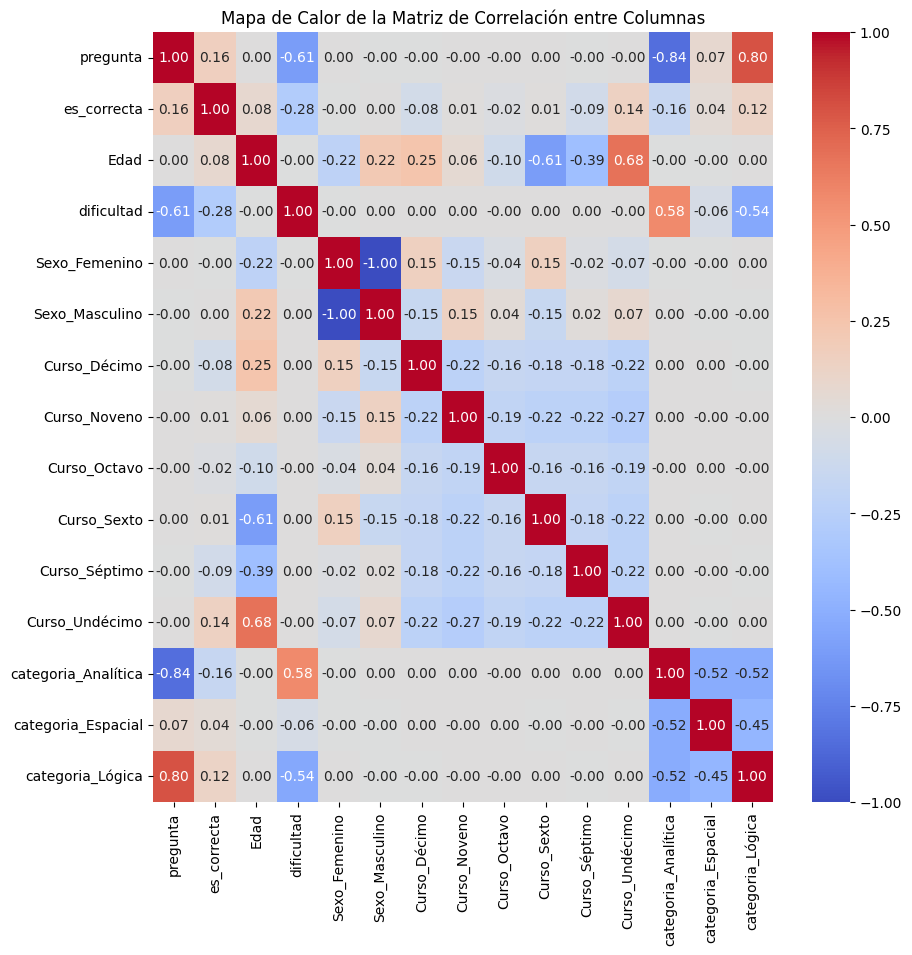

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = train_df_encoded.corr(numeric_only=True)

# Visualizar la matriz de correlación con un mapa de calor
plt.figure(figsize=(10, 10))  # Ajusta el tamaño de la figura según necesites
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Mapa de Calor de la Matriz de Correlación entre Columnas')
plt.show()

Antes de empezar a realizar el entrenamiento del modelo, se debe dividir en las columnas que no tienen la columna objetivo, así como con la columna que tiene la columna objetivo, hay un breve señalamiento, dado que el modelo catboost permite trabajar con datos categóricos, por lo tanto su entrenamiento va a ser diferente al resto de los modelos, es así que el train_test_split es diferente con un breve comentario inicial

In [8]:
Y_train = train_df_encoded["es_correcta"]
X_train = train_df_encoded.drop(['es_correcta'], axis=1)

In [10]:
# Para Catboost
Y_train_ = df_modelo_util["es_correcta"]
X_train_ = df_modelo_util.drop(['es_correcta'], axis=1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)

In [11]:
# Para Catboost
x_train_, x_test_, y_train_, y_test_ = train_test_split(X_train_, Y_train_, test_size=0.3, random_state=42)

# ENTRENAMIENTO DE LOS DIFERENTES MODELOS
Para el entrenamiento de los modelos, se han utilizado hasta el momento Logistic Regression, Decision Tree Classifier, Support Vector Machine Classifier, K-Neighbors Classifier, Multinomial NB, Catboost, LightGBM, XGBoost, Random Forest Classifier, Extra Trees Classifier, y la estructura del entrenamiento para cada uno de los modelos sigue la siguiente estructura:
* Se carga el modelo con los diferentes hiperparametros para entrenar, pero con un intervalo de búsqueda, estos pueden ser enteros, float, o categóricos, así como otros hiperparametros que permiten definir algunos requisitos necesarios de acuerdo a cada uno de los diferentes modelos.
* El uso de StratifiedKfold me va a permitir utilizar los datos divididos de diferentes formas para así evitar el overfitting en el entrenamiento y que este sólo aprenda las características de una parte de los datos, y precisamente se divide el conjunto de datos en diferentes capas, para luego promediar y obtener el mejor resultado.
* Dentro del bucle for se recorre y se entrena con cada uno de los diferentes conjuntos de datos, que se establece desde un comienzo en n_splits, se escogen los hiperparametros de acuerdo a la lista, y estos al final se van guardando en la lista especificada, donde se cálcula su respectivo promedio.
* Se inicia el estudio "study" el cuál ejecuta todo el proceso de la función.
* Se listan los mejores valores para los hiperparametros escogidos, y como se han intentado varias veces, agrego un markdown mostrando los diferentes valores, (es posible que sí sólo aparece un valor de estos, indique que siempre aparecen los mismos hiperparametros).
* Se cargan los hiperparametros con sus respectivos mejores valores al modelo
* Se entrena con los datos de entrenamiento x_train y y_train pertenecientes al train_test_split

# Logistic Regression

In [12]:
def objective(trial):
    model = linear_model.LogisticRegression(
        C=trial.suggest_float('C', 1e-4, 1e2, log=True),
        penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
        solver=trial.suggest_categorical('solver', ['liblinear', 'saga']),
        random_state=42, # Recomendado para reproducibilidad
        max_iter=1000
    )
    # Inicializar la validación cruzada. Usar StratifiedKFold para problemas de clasificación
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    # Bucle de validación cruzada sobre el conjunto de entrenamiento (X, y)
    for train_index, val_index in kf.split(x_train, y_train):
        X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Crear y entrenar el modelo con los hiperparámetros sugeridos por Optuna
        model = linear_model.LogisticRegression(**trial.params)
        model.fit(X_train_fold, y_train_fold)

        # Predecir probabilidades para calcular el AUC
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calcular el AUC del pliegue y guardarlo
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    # La función objective debe devolver el promedio de las puntuaciones de AUC
    # Optuna intentará maximizar este valor
    return np.mean(auc_scores)

In [13]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [14]:
study_lr = optuna.create_study(study_name="logistic_regression", direction="maximize", sampler=sampler)
study_lr.optimize(objective, n_trials=100)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

In [15]:
#evaluate the trial
print("Number of finished trials: ", len(study_lr.trials))
print("Best trial:")
trial = study_lr.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.6594088669950738
  Params: 
    C: 0.07138174488032967
    penalty: l2
    solver: liblinear


* Number of finished trials:  100
* Best trial:
  * Value:  0.6594088669950738
  * Params:
    * C: 0.07138174488032967
    * penalty: l2
    * solver: liblinear

In [16]:
Logistic_Regression_Tuned = linear_model.LogisticRegression(
    **trial.params,
    random_state=42
)

In [17]:
#Logistic_Regression = linear_model.LogisticRegression(solver='liblinear')
Logistic_Regression_Tuned.fit(x_train, y_train)

LogisticRegression(C=0.07138174488032967, random_state=42, solver='liblinear')

In [ ]:
Correct_Answers = Logistic_Regression_Tuned.predict(x_test)

# Decision Tree Classifier

In [18]:
def objective(trial):
    model = DecisionTreeClassifier(
        max_depth=trial.suggest_int('max_depth', 3, 20),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 5, 50),
        criterion=trial.suggest_categorical('criterion', ['gini', 'entropy']),
        random_state=42,
    )
    # Inicializar la validación cruzada. Usar StratifiedKFold para problemas de clasificación
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    # Bucle de validación cruzada sobre el conjunto de entrenamiento (X, y)
    for train_index, val_index in kf.split(x_train, y_train):
        X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Crear y entrenar el modelo con los hiperparámetros sugeridos por Optuna
        model = DecisionTreeClassifier(**trial.params)
        model.fit(X_train_fold, y_train_fold)

        # Predecir probabilidades para calcular el AUC
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calcular el AUC del pliegue y guardarlo
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    # La función objective debe devolver el promedio de las puntuaciones de AUC
    # Optuna intentará maximizar este valor
    return np.mean(auc_scores)

In [19]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [20]:
study_dtc = optuna.create_study(study_name="decision_tree_classifier", direction="maximize", sampler=sampler)
study_dtc.optimize(objective, n_trials=100)

In [21]:
#evaluate the trial
print("Number of finished trials: ", len(study_dtc.trials))
print("Best trial:")
trial = study_dtc.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.7073713738368911
  Params: 
    max_depth: 5
    min_samples_leaf: 6
    criterion: entropy


* Number of finished trials:  100
* Best trial:
  * Value:  0.7073713738368911
  * Params:
    * max_depth: 5
    * min_samples_leaf: 6
    * criterion: entropy
* Segundo intento:
* Number of finished trials:  100
* Best trial:
  * Value:  0.7070785440613027
  * Params:
    * max_depth: 5
    * min_samples_leaf: 7
    * criterion: entropy
* Tercer intento:
* Number of finished trials:  100
* Best trial:
  * Value:  0.7075383141762452
  * Params:
    * max_depth: 5
    * min_samples_leaf: 7
    * criterion: entropy

In [22]:
Decision_Tree_Classifier_Tuned = DecisionTreeClassifier(
    **trial.params,
    random_state=42
)

In [23]:
#Decision_Tree_Classifier = DecisionTreeClassifier(max_depth=5)
Decision_Tree_Classifier_Tuned.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=6,
                       random_state=42)

In [ ]:
Correct_Answers = Decision_Tree_Classifier_Tuned.predict(x_test)

# Support Vector Classifier

In [24]:
def objective(trial):
    model = SVC(
        C=trial.suggest_float('C', 1e-3, 1e3, log=True),
        kernel=trial.suggest_categorical('kernel', ['rbf', 'linear']),
        gamma=trial.suggest_float('gamma', 1e-4, 1e-1, log=True),
        random_state=42,
        probability=True
    )
    # Inicializar la validación cruzada. Usar StratifiedKFold para problemas de clasificación
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    # Bucle de validación cruzada sobre el conjunto de entrenamiento (X, y)
    for train_index, val_index in kf.split(x_train, y_train):
        X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Crear y entrenar el modelo con los hiperparámetros sugeridos por Optuna
        model = SVC(**trial.params,probability=True,)
        model.fit(X_train_fold, y_train_fold)

        # Predecir probabilidades para calcular el AUC
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calcular el AUC del pliegue y guardarlo
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    # La función objective debe devolver el promedio de las puntuaciones de AUC
    # Optuna intentará maximizar este valor
    return np.mean(auc_scores)

In [25]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [26]:
study_svc = optuna.create_study(study_name="support_vector_classifier", direction="maximize", sampler=sampler)
study_svc.optimize(objective, n_trials=100)

In [27]:
#evaluate the trial
print("Number of finished trials: ", len(study_svc.trials))
print("Best trial:")
trial = study_svc.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.6983333333333334
  Params: 
    C: 1.9769004015514167
    kernel: rbf
    gamma: 0.06287905771986477


* Number of finished trials:  100
* Best trial:
  * Value:  0.6981759715380405
  * Params:
    * C: 1.0947260185033139
    * kernel: rbf
    * gamma: 0.09881401191236125
* Segundo intento:
* Number of finished trials:  100
* Best trial:
  * Value:  0.6979460864805691
  * Params:
    * C: 1.0947260185033139
    * kernel: rbf
    * gamma: 0.09881401191236125
* Tercer Intento
* Number of finished trials:  100
* Best trial:
  * Value:  0.6981773399014777
  * Params:
    * C: 1.0947260185033139
    * kernel: rbf
    * gamma: 0.09881401191236125

In [28]:
Support_Vector_Classifier_Tuned = SVC(
    **trial.params,
    random_state=42,
    probability=True
)

In [29]:
#Support_Vector_Classifier = SVC(kernel='linear', probability=True)
Support_Vector_Classifier_Tuned.fit(x_train, y_train)

SVC(C=1.9769004015514167, gamma=0.06287905771986477, probability=True,
    random_state=42)

In [ ]:
Correct_Answers = Support_Vector_Classifier_Tuned.predict(x_test)

# K-Neighbors Classifier

In [30]:
def objective(trial):
    model = KNeighborsClassifier(
        n_neighbors=trial.suggest_int('n_neighbors', 3, 31, step=2),
        weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
        p=trial.suggest_int('p', 1, 2)
    )
    # Inicializar la validación cruzada. Usar StratifiedKFold para problemas de clasificación
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    # Bucle de validación cruzada sobre el conjunto de entrenamiento (X, y)
    for train_index, val_index in kf.split(x_train, y_train):
        X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Crear y entrenar el modelo con los hiperparámetros sugeridos por Optuna
        model = KNeighborsClassifier(**trial.params)
        model.fit(X_train_fold, y_train_fold)

        # Predecir probabilidades para calcular el AUC
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calcular el AUC del pliegue y guardarlo
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    # La función objective debe devolver el promedio de las puntuaciones de AUC
    # Optuna intentará maximizar este valor
    return np.mean(auc_scores)

In [31]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [32]:
study_kn = optuna.create_study(study_name="k_neighbors_classifier", direction="maximize", sampler=sampler)
study_kn.optimize(objective, n_trials=100)

In [33]:
#evaluate the trial
print("Number of finished trials: ", len(study_kn.trials))
print("Best trial:")
trial = study_kn.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.6932484948002189
  Params: 
    n_neighbors: 13
    weights: uniform
    p: 2


* Number of finished trials:  100
* Best trial:
  * Value:  0.6932484948002189
  * Params:
    * n_neighbors: 13
    * weights: uniform
    * p: 2

In [34]:
K_Neighbors_Classifier_Tuned = KNeighborsClassifier(
    **trial.params
)

In [35]:
#K_Neighbors_Classifier = KNeighborsClassifier(n_neighbors=5)
K_Neighbors_Classifier_Tuned.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=13)

In [ ]:
Correct_Answers = K_Neighbors_Classifier_Tuned.predict(x_test)

# Multinomial NB

In [36]:
def objective(trial):
    model = MultinomialNB(
        alpha=trial.suggest_float('alpha', 1e-2, 1e1, log=True),
        fit_prior=trial.suggest_categorical('fit_prior', [True, False])
    )
    # Inicializar la validación cruzada. Usar StratifiedKFold para problemas de clasificación
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    # Bucle de validación cruzada sobre el conjunto de entrenamiento (X, y)
    for train_index, val_index in kf.split(x_train, y_train):
        X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Crear y entrenar el modelo con los hiperparámetros sugeridos por Optuna
        model = MultinomialNB(**trial.params)
        model.fit(X_train_fold, y_train_fold)

        # Predecir probabilidades para calcular el AUC
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calcular el AUC del pliegue y guardarlo
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    # La función objective debe devolver el promedio de las puntuaciones de AUC
    # Optuna intentará maximizar este valor
    return np.mean(auc_scores)

In [37]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [38]:
study_NB = optuna.create_study(study_name="multinomial_NB", direction="maximize", sampler=sampler)
study_NB.optimize(objective, n_trials=100)

In [39]:
#evaluate the trial
print("Number of finished trials: ", len(study_NB.trials))
print("Best trial:")
trial = study_NB.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.6023426382047071
  Params: 
    alpha: 9.964544559931403
    fit_prior: True


* Number of finished trials:  100
* Best trial:
  * Value:  0.6023426382047071
  * Params:
    * alpha: 9.964544559931403
    * fit_prior: True

In [40]:
Multinomial_NB_Tuned = MultinomialNB(
    **trial.params
)

In [41]:
#Multinomial_NB = MultinomialNB(alpha=0.01, fit_prior=True)
Multinomial_NB_Tuned.fit(x_train, y_train)

MultinomialNB(alpha=9.964544559931403)

In [ ]:
Correct_Answers = Multinomial_NB_Tuned.predict(x_test)

# Catboost

In [42]:
categorical_features_names = ["Sexo", "Curso", "categoria"]

In [43]:
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 10),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-3, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=0,
        #cat_features=categorical_features_names,
        #task_type='GPU'
    )
    # Inicializar la validación cruzada. Usar StratifiedKFold para problemas de clasificación
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    # Bucle de validación cruzada sobre el conjunto de entrenamiento (X, y)
    for train_index, val_index in kf.split(x_train_, y_train_):
        X_train_fold, X_val_fold = x_train_.iloc[train_index], x_train_.iloc[val_index]
        y_train_fold, y_val_fold = y_train_.iloc[train_index], y_train_.iloc[val_index]

        # Crear y entrenar el modelo con los hiperparámetros sugeridos por Optuna
        model = catboost.CatBoostClassifier(**trial.params)
        model.fit(X_train_fold, y_train_fold,
                  cat_features=categorical_features_names,
                  eval_set=(X_val_fold, y_val_fold),
                  early_stopping_rounds=50,  # Importante para prevenir sobreajuste
                  verbose=0)

        # Predecir probabilidades para calcular el AUC
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calcular el AUC del pliegue y guardarlo
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    # La función objective debe devolver el promedio de las puntuaciones de AUC
    # Optuna intentará maximizar este valor
    return np.mean(auc_scores)

In [44]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [45]:
study_cat = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study_cat.optimize(objective, n_trials=100)

In [46]:
#evaluate the trial
print("Number of finished trials: ", len(study_cat.trials))
print("Best trial:")
trial = study_cat.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.7161754241926656
  Params: 
    iterations: 502
    learning_rate: 0.03531954032861103
    depth: 7
    l2_leaf_reg: 11.863926568305
    bootstrap_type: Bayesian
    random_strength: 0.006664751587124321
    bagging_temperature: 0.1889800012590728
    od_type: Iter
    od_wait: 12


* Number of finished trials:  100
* Best trial:
  * Value:  0.7161754241926656
  * Params:
    * iterations: 502
    * learning_rate: 0.03531954032861103
    * depth: 7
    * l2_leaf_reg: 11.863926568305
    * bootstrap_type: Bayesian
    * random_strength: 0.006664751587124321
    * bagging_temperature: 0.1889800012590728
    * od_type: Iter
    * od_wait: 12

In [47]:
Cat_Boost_Classifier_Tuned = catboost.CatBoostClassifier(
    **trial.params,
    verbose=0,
    cat_features=categorical_features_names
)

In [48]:
Cat_Boost_Classifier_Tuned.fit(x_train_, y_train_)

## LightGBM

In [49]:
def objective(trial):
    model = lgb.LGBMClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 1000),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 2, 7),
        num_leaves=trial.suggest_int("num_leaves", 5, 31),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 50),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        reg_lambda= trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        #device='cuda',
        objective= 'binary',
        metric= 'auc',
        n_jobs= -1,
        random_state= 42,
        verbose= -1
    )
    # Inicializar la validación cruzada. Usar StratifiedKFold para problemas de clasificación
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    # Bucle de validación cruzada sobre el conjunto de entrenamiento (X, y)
    # Asumo que las variables x_train y y_train están disponibles globalmente o se pasan
    for train_index, val_index in kf.split(x_train, y_train):
        X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Crear y entrenar el modelo con los hiperparámetros sugeridos por Optuna
        model = lgb.LGBMClassifier(**trial.params) # Usar Regressor

        # El conjunto de evaluación es importante para el early stopping
        model.fit(X_train_fold, y_train_fold,
                       eval_set=[(X_val_fold, y_val_fold)],
                       eval_metric='auc',
                       callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)])

        # Predecir probabilidades para calcular el AUC
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calcular el AUC del pliegue y guardarlo
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    # La función objective debe devolver el promedio de las puntuaciones de AUC
    # Optuna intentará maximizar este valor
    return np.mean(auc_scores)

In [50]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [51]:
study_lgbm = optuna.create_study(study_name="lightGBM", direction="maximize", sampler=sampler)
study_lgbm.optimize(objective, n_trials=100)

Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [52]:
#evaluate the trial
print("Number of finished trials: ", len(study_lgbm.trials))
print("Best trial:")
trial = study_lgbm.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.7294485495347565
  Params: 
    n_estimators: 546
    learning_rate: 0.18224773617652046
    max_depth: 6
    num_leaves: 24
    min_child_samples: 10
    reg_alpha: 6.344318246214296e-08
    reg_lambda: 2.9467352325605063
    subsample: 0.8337398610267208
    colsample_bytree: 0.8668668095883789


* Number of finished trials:  100
* Best trial:
  * Value:  0.7294485495347565
  * Params:
    * n_estimators: 546
    * learning_rate: 0.18224773617652046
    * max_depth: 6
    * num_leaves: 24
    * min_child_samples: 10
    * reg_alpha: 6.344318246214296e-08
    * reg_lambda: 2.9467352325605063
    * subsample: 0.8337398610267208
    * colsample_bytree: 0.8668668095883789

In [53]:
LightGBM_Classifier_Tuned = lgb.LGBMClassifier(
    **trial.params,
    verbose=-1,
    objective= 'binary',
    metric= 'auc',
    n_jobs= -1,
    random_state= 42
)

In [54]:
LightGBM_Classifier_Tuned.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.8668668095883789,
               learning_rate=0.18224773617652046, max_depth=6, metric='auc',
               min_child_samples=10, n_estimators=546, n_jobs=-1, num_leaves=24,
               objective='binary', random_state=42,
               reg_alpha=6.344318246214296e-08, reg_lambda=2.9467352325605063,
               subsample=0.8337398610267208, verbose=-1)

## XGBoost

In [55]:
#from sklearn.model_selection import StratifiedKFold
#from xgboost.callback import EarlyStopping
def objective(trial):
    model = xgb.XGBClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 1000),
        learning_rate=trial.suggest_float("learning_rate", 5e-3, 0.3, log=True),
        max_depth=trial.suggest_int("max_depth", 3, 7),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        objective= 'binary:logistic',
        eval_metric= 'auc',
        #device='cuda',
        #tree_method='gpu_hist',
        n_jobs= -1,
        random_state= 42,
        verbosity= 0,
    )
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    # NOTA: La variable early_stopping ya no se define

    for train_index, val_index in kf.split(x_train, y_train):
        X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Entrenar el modelo (XGBoost funciona mejor si se re-instancia aquí con trial.params
        # o si se usa el modelo definido fuera y se resetean los parámetros, pero la forma más limpia es usar la sintaxis de **trial.params** o variables locales)

        # 🟢 Solución del TypeError: Usar el argumento antiguo
        model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  #early_stopping_rounds=50, # 🟢 Revertido a la sintaxis que tu versión de XGBoost reconoce
                  verbose=False)

        # Predecir probabilidades
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calcular el AUC
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    return np.mean(auc_scores)

In [56]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [57]:
study_xgb = optuna.create_study(study_name="xgboost", direction="maximize", sampler=sampler)
study_xgb.optimize(objective, n_trials=100)

In [58]:
#evaluate the trial
print("Number of finished trials: ", len(study_xgb.trials))
print("Best trial:")
trial = study_xgb.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.7150027367268746
  Params: 
    n_estimators: 512
    learning_rate: 0.006964844236398066
    max_depth: 7
    reg_lambda: 1.0872213788214996e-08
    subsample: 0.8377987613852541
    colsample_bytree: 0.7242968342870454
    reg_alpha: 0.505963442515956


* Number of finished trials:  100
* Best trial:
  * Value:  0.7150027367268746
  * Params:
    * n_estimators: 512
    * learning_rate: 0.006964844236398066
    * max_depth: 7
    * reg_lambda: 1.0872213788214996e-08
    * subsample: 0.8377987613852541
    * colsample_bytree: 0.7242968342870454
    * reg_alpha: 0.505963442515956

In [59]:
XGB_Classifier_Tuned = xgb.XGBClassifier(
    **trial.params,
    objective= 'binary:logistic',
        eval_metric= 'auc',
        n_jobs= -1,
        random_state= 42,
        verbosity= 0,
)

In [60]:
XGB_Classifier_Tuned.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7242968342870454, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.006964844236398066,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=512, n_jobs=-1,
              num_parallel_tree=None, ...)

## Random Forest

In [61]:
def objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        max_depth = trial.suggest_int('max_depth', 3, 15),
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20),
        min_samples_leaf = trial.suggest_int('min_samples_leaf',2 , 10),
        max_features = trial.suggest_categorical('max_features', ['sqrt','log2',None]),
        class_weight = trial.suggest_categorical('class_weight', ['balanced',None]),
        n_jobs=-1,
        random_state=42

    )
    # Inicializar la validación cruzada. Usar StratifiedKFold para problemas de clasificación
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    # NOTA: La variable early_stopping ya no se define

    for train_index, val_index in kf.split(x_train, y_train):
        X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Entrenar el modelo (XGBoost funciona mejor si se re-instancia aquí con trial.params
        # o si se usa el modelo definido fuera y se resetean los parámetros, pero la forma más limpia es usar la sintaxis de **trial.params** o variables locales)
        model = RandomForestClassifier(**trial.params)
        # 🟢 Solución del TypeError: Usar el argumento antiguo
        model.fit(X_train_fold, y_train_fold)

        # Predecir probabilidades
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calcular el AUC
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    return np.mean(auc_scores)

In [62]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [63]:
study_rfc = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
study_rfc.optimize(objective, n_trials=100)

In [64]:
#evaluate the trial
print("Number of finished trials: ", len(study_rfc.trials))
print("Best trial:")
trial = study_rfc.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.7188341543513956
  Params: 
    n_estimators: 187
    max_depth: 9
    min_samples_split: 19
    min_samples_leaf: 2
    max_features: None
    class_weight: None


* Number of finished trials:  100
* Best trial:
  * Value:  0.7188341543513956
  * Params:
    * n_estimators: 187
    * max_depth: 9
    * min_samples_split: 19
    * min_samples_leaf: 2
    * max_features: None
    * class_weight: None

In [65]:
Random_Forest_Classifier_Tuned = RandomForestClassifier(
    **trial.params,
    n_jobs=-1,
    random_state=42
)

In [66]:
Random_Forest_Classifier_Tuned.fit(x_train, y_train)

RandomForestClassifier(max_depth=9, max_features=None, min_samples_leaf=2,
                       min_samples_split=19, n_estimators=187, n_jobs=-1,
                       random_state=42)

## Extra Trees

In [67]:
def objective(trial):
    model = ExtraTreesClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 400),
        max_depth = trial.suggest_int('max_depth', 5, 20),
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20),
        min_samples_leaf = trial.suggest_int('min_samples_leaf',2 , 10),
        max_features = trial.suggest_categorical('max_features', ['sqrt','log2',None]),
        bootstrap = trial.suggest_categorical('bootstrap', [True,False]),
        criterion = trial.suggest_categorical('criterion', ['gini', 'entropy']),
        n_jobs=-1,
        random_state=42

    )
    # Inicializar la validación cruzada. Usar StratifiedKFold para problemas de clasificación
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_scores = []

    # NOTA: La variable early_stopping ya no se define

    for train_index, val_index in kf.split(x_train, y_train):
        X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        # Entrenar el modelo (XGBoost funciona mejor si se re-instancia aquí con trial.params
        # o si se usa el modelo definido fuera y se resetean los parámetros, pero la forma más limpia es usar la sintaxis de **trial.params** o variables locales)
        model = ExtraTreesClassifier(**trial.params)
        # 🟢 Solución del TypeError: Usar el argumento antiguo
        model.fit(X_train_fold, y_train_fold)

        # Predecir probabilidades
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calcular el AUC
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    return np.mean(auc_scores)

In [68]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [69]:
study_etc = optuna.create_study(study_name="extra_trees", direction="maximize", sampler=sampler)
study_etc.optimize(objective, n_trials=100)

In [70]:
#evaluate the trial
print("Number of finished trials: ", len(study_etc.trials))
print("Best trial:")
trial = study_etc.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.7178229337712098
  Params: 
    n_estimators: 212
    max_depth: 15
    min_samples_split: 15
    min_samples_leaf: 7
    max_features: None
    bootstrap: False
    criterion: entropy


* Number of finished trials:  100
* Best trial:
  * Value:  0.7178229337712098
  * Params:
    * n_estimators: 212
    * max_depth: 15
    * min_samples_split: 15
    * min_samples_leaf: 7
    * max_features: None
    * bootstrap: False
    * criterion: entropy

In [71]:
Extra_Trees_Classifier_Tuned = ExtraTreesClassifier(
    **trial.params,
    n_jobs=-1,
    random_state=42
)

In [72]:
Extra_Trees_Classifier_Tuned.fit(x_train, y_train)

ExtraTreesClassifier(criterion='entropy', max_depth=15, max_features=None,
                     min_samples_leaf=7, min_samples_split=15, n_estimators=212,
                     n_jobs=-1, random_state=42)

## Gráfica Roc y Valor AUC de cada uno de los modelos, en comparación
Luego de realizar los pasos anteriores, se procede a realizar una comparación entre los valores de AUC, y la curva ROC en conjunto para así poder verificar cuál de estos modelos puede ser el mejor, se debe tener en cuenta que para que sea aceptable el valor de la curva debe estar mas cerca de la esquina, y el valor del AUC debe ser superior a 70 para ser aunque sea aceptable, o mayor a 80 para obtener mejores resultados, con datos nuevos

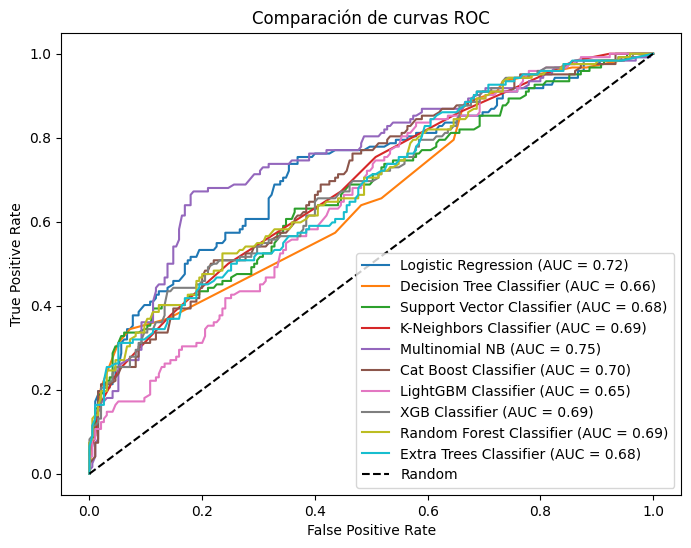

In [73]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_proba_lr = Logistic_Regression_Tuned.predict_proba(x_test)[:, 1]
y_pred_proba_dtc = Decision_Tree_Classifier_Tuned.predict_proba(x_test)[:, 1]
y_pred_proba_svc = Support_Vector_Classifier_Tuned.predict_proba(x_test)[:, 1]
y_pred_proba_knc = K_Neighbors_Classifier_Tuned.predict_proba(x_test)[:, 1]
y_pred_proba_mnb = Multinomial_NB_Tuned.predict_proba(x_test)[:, 1]
y_pred_proba_cat = Cat_Boost_Classifier_Tuned.predict_proba(x_test_)[:, 1]
y_pred_proba_lgbm = LightGBM_Classifier_Tuned.predict_proba(x_test)[:, 1]
y_pred_proba_xgb = XGB_Classifier_Tuned.predict_proba(x_test)[:, 1]
y_pred_proba_rfc = Random_Forest_Classifier_Tuned.predict_proba(x_test)[:, 1]
y_pred_proba_etc = Extra_Trees_Classifier_Tuned.predict_proba(x_test)[:, 1]
# Ejemplo: lista de modelos y sus nombres
modelos = {
    "Logistic Regression": y_pred_proba_lr,
    "Decision Tree Classifier": y_pred_proba_dtc,
    "Support Vector Classifier": y_pred_proba_svc,
    "K-Neighbors Classifier": y_pred_proba_knc,
    "Multinomial NB": y_pred_proba_mnb,
    "Cat Boost Classifier": y_pred_proba_cat,
    "LightGBM Classifier": y_pred_proba_lgbm,
    "XGB Classifier": y_pred_proba_xgb,
    "Random Forest Classifier": y_pred_proba_rfc,
    "Extra Trees Classifier": y_pred_proba_etc
}

plt.figure(figsize=(8,6))

# Graficar cada modelo
for nombre, y_pred_proba in modelos.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f})')

# Línea base (clasificador aleatorio)
plt.plot([0,1], [0,1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación de curvas ROC')
plt.legend(loc='lower right')
plt.show()

La gáfica nos muestra que los mejores resultados fueron obtenidos por los modelos de Multinomial NB con 0.75, Logistic Regression con 0.72, Catboost Classifier con 0.70, y otros modelos con resultados cercanos a 0.69

# Metamodelo

Debido a los bajos resultados anteriores, se propone realizar un metamodelo, este funciona de la siguiente forma, se escogen las mejores predicciones de los modelos y en base a estos resultados se entrena un nuevo modelo para que pueda escoger los mejores valores y superar el umbral esperado.

In [ ]:
# Extraer los mejores parámetros como diccionarios
best_NB_params = study_NB.best_params
best_lr_params = study_lr.best_params
best_cat_params = study_cat.best_params
best_xgb_params = study_xgb.best_params
best_kn_params = study_kn.best_params

In [ ]:
# ------------------------------------------------------------------------------
# 0. ASUNCIONES Y CONFIGURACIÓN (Asegúrate de que estas variables existan)
# ------------------------------------------------------------------------------
# X_train, Y_train (o df_train['accident_risk']), BEST_CB_PARAMS, BEST_XGB_PARAMS
N_SPLITS = 10
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
#kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# ------------------------------------------------------------------------------
# 1. INICIALIZACIÓN (Afuera de los bucles/funciones)
# ------------------------------------------------------------------------------

# Inicializa arreglos para guardar las predicciones OOF para el 100% de X_train
# ¡Esto resuelve el NameError!
oof_preds_multinomial_NB = np.zeros(len(X_train))
oof_preds_logistic_regression = np.zeros(len(X_train))
oof_preds_catboost = np.zeros(len(X_train))
oof_preds_xgboost = np.zeros(len(X_train))
oof_preds_kneighbors = np.zeros(len(X_train))
Y_meta = train_df_encoded["es_correcta"] # Tu target completo

# ------------------------------------------------------------------------------
# 2. BUCLE K-FOLD PARA GENERAR LOS VALORES OOF
# ------------------------------------------------------------------------------

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, Y_train)):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    Y_train_fold, Y_val_fold = Y_train.iloc[train_idx], Y_train.iloc[val_idx]

    # -- Multinomial NB --
    # Usar los mejores HPs (BEST_CB_PARAMS)
    Multinomial_NB_Tuned = MultinomialNB(**best_NB_params)
    Multinomial_NB_Tuned.fit(X_train_fold, Y_train_fold)

     # 🚨 PREDICCIÓN Y ASIGNACIÓN OOF:
    # Llenamos las posiciones del fold de validación con las predicciones
    oof_preds_multinomial_NB[val_idx] = Multinomial_NB_Tuned.predict_proba(X_val_fold)[:, 1]

    # -- Logistic Regression --
    # Usar los mejores HPs (BEST_CB_PARAMS)
    Logistic_Regression_Tuned = linear_model.LogisticRegression(**best_lr_params, random_state=45)
    Logistic_Regression_Tuned.fit(X_train_fold, Y_train_fold)

     # 🚨 PREDICCIÓN Y ASIGNACIÓN OOF:
    # Llenamos las posiciones del fold de validación con las predicciones
    oof_preds_logistic_regression[val_idx] = Logistic_Regression_Tuned.predict_proba(X_val_fold)[:, 1]

    # -- CatBoost --
    # Usar los mejores HPs (BEST_CB_PARAMS)
    Cat_Boost_Classifier_Tuned = catboost.CatBoostClassifier(**best_cat_params, verbose=0, random_seed=42)
    Cat_Boost_Classifier_Tuned.fit(X_train_fold, Y_train_fold)

    # 🚨 PREDICCIÓN Y ASIGNACIÓN OOF:
    # Llenamos las posiciones del fold de validación con las predicciones
    oof_preds_catboost[val_idx] = Cat_Boost_Classifier_Tuned.predict_proba(X_val_fold)[:, 1]

    # -- XGBoost --
    # Usar los mejores HPs (BEST_XGB_PARAMS)
    XGB_Classifier_Tuned = xgb.XGBClassifier(**best_xgb_params, verbosity=0, random_state=42)
    XGB_Classifier_Tuned.fit(X_train_fold, Y_train_fold)

    # 🚨 PREDICCIÓN Y ASIGNACIÓN OOF:
    oof_preds_xgboost[val_idx] = XGB_Classifier_Tuned.predict_proba(X_val_fold)[:, 1]

    # -- K Neighbors --
    # Usar los mejores HPs (BEST_XGB_PARAMS)
    K_Neighbors_Classifier_Tuned = KNeighborsClassifier(**best_kn_params)
    K_Neighbors_Classifier_Tuned.fit(X_train_fold, Y_train_fold)

    # 🚨 PREDICCIÓN Y ASIGNACIÓN OOF:
    oof_preds_kneighbors[val_idx] = K_Neighbors_Classifier_Tuned.predict_proba(X_val_fold)[:, 1]

# ------------------------------------------------------------------------------
# 3. CREACIÓN DEL DATAFRAME META (AHORA FUNCIONAL)
# ------------------------------------------------------------------------------

X_meta = pd.DataFrame({
    'Mulinomial_NB_Pred': oof_preds_multinomial_NB, # Usa el array lleno
    'Logistic_Regression_Pred': oof_preds_logistic_regression, # Usa el array lleno
    'CatBoost_Pred': oof_preds_catboost, # Usa el array lleno
    'XGBoost_Pred': oof_preds_xgboost,   # Usa el array lleno,
    'KNeighbors_Pred': oof_preds_kneighbors # Usa el array lleno
})
# Y_meta ya está definido

X_meta.head()

,Mulinomial_NB_Pred,Logistic_Regression_Pred,CatBoost_Pred,XGBoost_Pred,KNeighbors_Pred
0,0.108319,0.214118,0.049626,0.077757,0.076923
1,0.108319,0.214118,0.049626,0.077757,0.076923
2,0.108319,0.214118,0.049626,0.077757,0.076923
3,0.100422,0.229994,0.009618,0.056744,0.000000
4,0.103958,0.199900,0.010592,0.061114,0.000000


Se escoge LightGBM, pero puede ser otro modelo diferente

In [ ]:
def objective(trial):
    model = lgb.LGBMClassifier(
        n_estimators=trial.suggest_int("n_estimators", 50, 1000),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        max_depth=trial.suggest_int("max_depth", 2, 7),
        num_leaves=trial.suggest_int("num_leaves", 5, 31),
        min_child_samples=trial.suggest_int("min_child_samples", 10, 50),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        reg_lambda= trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        subsample=trial.suggest_float("subsample", 0.6, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
        #device='cuda',
        objective= 'binary',
        metric= 'auc',
        n_jobs= -1,
        random_state= 42,
        verbose= -1
    )
    # Inicializar la validación cruzada. Usar StratifiedKFold para problemas de clasificación
    kf_meta = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    auc_meta_scores = []

    # Bucle de validación cruzada sobre el conjunto de entrenamiento (X, y)
    # Asumo que las variables x_train y y_train están disponibles globalmente o se pasan
    for train_index, val_index in kf_meta.split(X_meta, Y_meta):
        X_train_fold, X_val_fold = X_meta.iloc[train_index], X_meta.iloc[val_index]
        Y_train_fold, Y_val_fold = Y_meta.iloc[train_index], Y_meta.iloc[val_index]

        # Crear y entrenar el modelo con los hiperparámetros sugeridos por Optuna
        model = lgb.LGBMClassifier(**trial.params) # Usar Regressor

        # El conjunto de evaluación es importante para el early stopping
        model.fit(X_train_fold, Y_train_fold,
                       eval_set=[(X_val_fold, Y_val_fold)],
                       eval_metric='auc',
                       callbacks=[lgb.early_stopping(stopping_rounds=30, verbose=False)])

        # Predecir probabilidades para calcular el AUC
        y_pred_proba = model.predict_proba(X_val_fold)[:, 1]

        # Calcular el AUC del pliegue y guardarlo
        auc = roc_auc_score(Y_val_fold, y_pred_proba)
        auc_meta_scores.append(auc)

    # La función objective debe devolver el promedio de las puntuaciones de AUC
    # Optuna intentará maximizar este valor
    return np.mean(auc_meta_scores)

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

In [ ]:
#Create the study
study_meta_lgbm = optuna.create_study(study_name="meta_lgbm_classifier_tuning", direction="maximize", sampler=sampler)
study_meta_lgbm.optimize(objective, n_trials=100)

In [ ]:
#evaluate the trial
print("Number of finished trials: ", len(study_meta_lgbm.trials))
print("Best trial:")
trial = study_meta_lgbm.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value:  0.7461932192553382
  Params: 
    n_estimators: 873
    learning_rate: 0.14918494021276424
    max_depth: 6
    num_leaves: 30
    min_child_samples: 15
    reg_alpha: 0.7184309578890397
    reg_lambda: 3.2504993773760766
    subsample: 0.6406567603376448
    colsample_bytree: 0.678544010018067


* Number of finished trials:  100
* Best trial:
  * Value:  0.7461932192553382
  * Params:
    * n_estimators: 873
    * learning_rate: 0.14918494021276424
    * max_depth: 6
    * num_leaves: 30
    * min_child_samples: 15
    * reg_alpha: 0.7184309578890397
    * reg_lambda: 3.2504993773760766
    * subsample: 0.6406567603376448
    * colsample_bytree: 0.678544010018067

In [ ]:
Meta_LightGBM_Classifier_Tuned = lgb.LGBMClassifier(
    **trial.params,
    verbosity=-1)

In [ ]:
Meta_LightGBM_Classifier_Tuned.fit(X_meta, Y_meta)

LGBMClassifier(colsample_bytree=0.678544010018067,
               learning_rate=0.14918494021276424, max_depth=6,
               min_child_samples=15, n_estimators=873, num_leaves=30,
               reg_alpha=0.7184309578890397, reg_lambda=3.2504993773760766,
               subsample=0.6406567603376448, verbosity=-1)

In [ ]:
predicciones = pd.DataFrame({
    "Multinomial NB": y_pred_proba_mnb,
    "Logistic Regression": y_pred_proba_lr,
    "Cat Boost Classifier": y_pred_proba_cat,
    "XGB Classifier": y_pred_proba_xgb,
    "K-Neighbors Classifier": y_pred_proba_knc,
})

In [ ]:
X_test_meta = pd.DataFrame({
    # Las columnas del metamodelo son las predicciones
    'Mulinomial_NB_Pred': predicciones['Multinomial NB'],
    'Logistic_Regression_Pred': predicciones['Logistic Regression'],
    'CatBoost_Pred': predicciones['Cat Boost Classifier'],
    'XGBoost_Pred': predicciones['XGB Classifier'],
    'KNeighbors_Pred': predicciones['K-Neighbors Classifier']
})

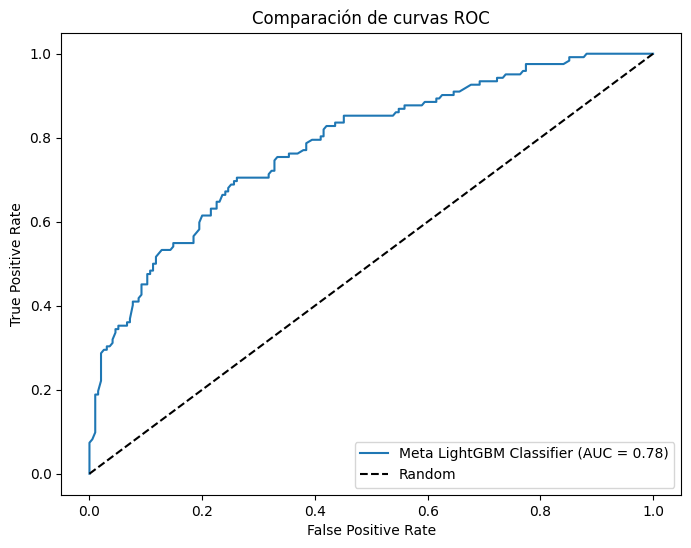

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred_proba_meta = Meta_LightGBM_Classifier_Tuned.predict_proba(X_test_meta)[:, 1]
# Ejemplo: lista de modelos y sus nombres
modelos = {
    "Meta LightGBM Classifier": y_pred_proba_meta,
}

plt.figure(figsize=(8,6))

# Graficar cada modelo
for nombre, y_pred_proba in modelos.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{nombre} (AUC = {roc_auc:.2f})')

# Línea base (clasificador aleatorio)
plt.plot([0,1], [0,1], 'k--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparación de curvas ROC')
plt.legend(loc='lower right')
plt.show()

Como era de esperarse, este resultado da una curva mejor así como un valor de AUC, superior llegando al 0.78, se espera que este metamodelo pueda realizar mejores predicciones de datos nuevos

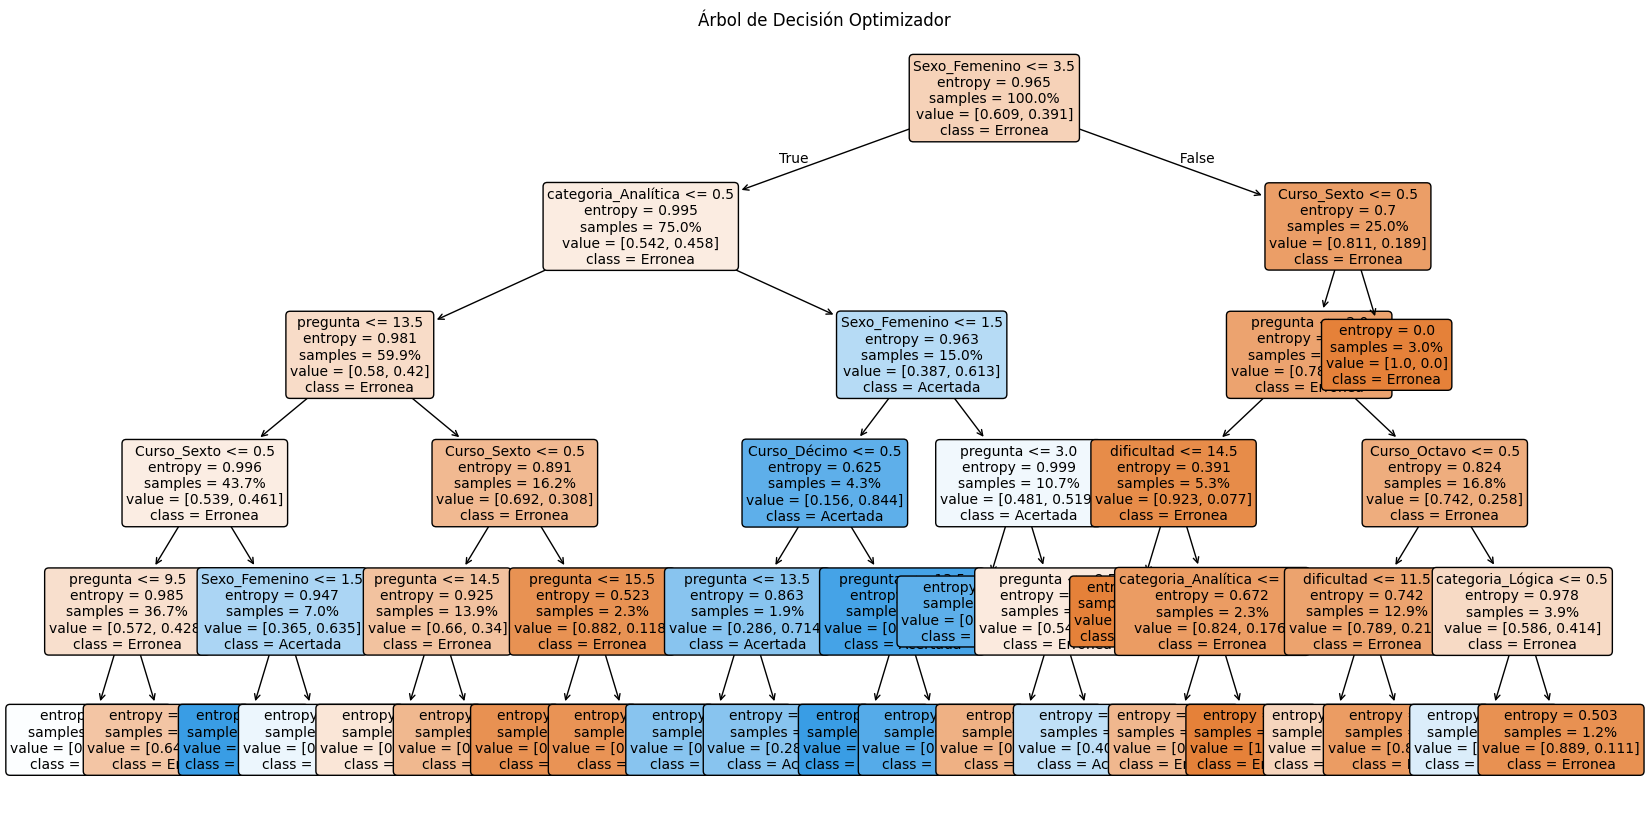

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
# 3. Preparar los nombres para la visualización
# Reemplaza con los nombres reales de tus 6 columnas
feature_names = ['pregunta', 'dificultad', 'Sexo_Femenino', 'Sexo_Masculino', 'Curso_Décimo', 'Curso_Noveno','Curso_Octavo','Curso_Sexto','Curso_Séptimo','Curso_Undécimo','categoria_Analítica','categoria_Espacial','categoria_Lógica']

# Define los nombres de las clases (ej. si tienes clasificación binaria 0 y 1)
class_names = ['Erronea', 'Acertada']

# 4. Generar la gráfica del árbol
plt.figure(figsize=(20, 10))
plot_tree(
    Decision_Tree_Classifier_Tuned,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,         # Colorea los nodos según la clase mayoritaria
    rounded=True,        # Bordes redondeados
    proportion=True,     # Muestra las proporciones de las muestras
    fontsize=10
)
plt.title("Árbol de Decisión Optimizador")
plt.show()

Es basante interesante que el modelo de arboles de decisión permita mostrar como se clasifica las diferentes ramas del árbol, y como el modelo funciona, es muy visual para poder realizar explicaciones posteriores.


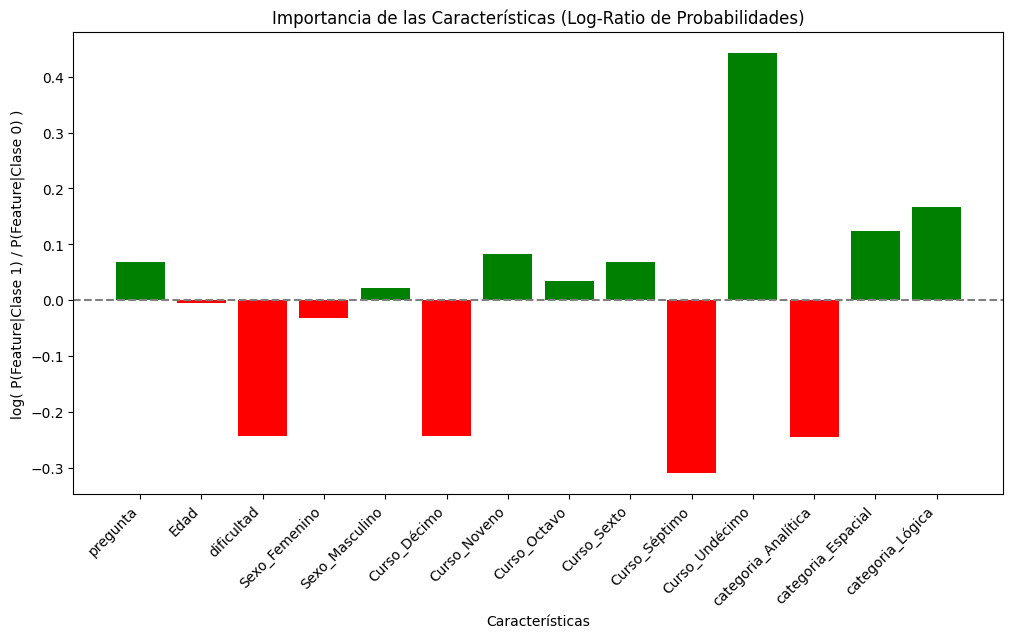

In [ ]:
log_prob_clase0 = Multinomial_NB_Tuned.feature_log_prob_[0]
log_prob_clase1 = Multinomial_NB_Tuned.feature_log_prob_[1]

# --- B. Cálculo del Ratio Logarítmico (Importancia) ---
# La diferencia logarítmica es equivalente al log del ratio:
# log(P(feature | Clase 1) / P(feature | Clase 0))
log_ratio = log_prob_clase1 - log_prob_clase0

# --- C. Visualización ---
feature_names = x_train.columns # Nombres de tus 6 columnas

plt.figure(figsize=(12, 6))
bars = plt.bar(feature_names, log_ratio, color=np.where(log_ratio > 0, 'green', 'red'))

plt.axhline(0, color='gray', linestyle='--') # Línea de referencia en cero

plt.title('Importancia de las Características (Log-Ratio de Probabilidades)')
plt.ylabel('log( P(Feature|Clase 1) / P(Feature|Clase 0) )')
plt.xlabel('Características')
plt.xticks(rotation=45, ha='right')

plt.show()

* Interpretación
 * Barras Verdes (Positivo): La feature contribuye fuertemente a predecir la Clase 1.

 * Barras Rojas (Negativo): La feature contribuye fuertemente a predecir la Clase 0.

 * Magnitud: Cuanto más alta o más baja sea la barra (más lejos del 0), más influyente es la característica.

Hasta este momento sólo se han utilizado dos métricas la curva ROC, y el valor de AUC, que me permiten tener una idea de como se puede comportar el modelo, pero en un futuro cercano se espera que se puedan tener otras métricas para poder evaluar el modelo, así como realizar una predicción, comparar con los resultados del estudiante que faltó, y ver que tan relacionadas estaban las métricas respecto a cada uno de los diferentes resultados.